In [7]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [21]:
palette_name = "rocket"

# Results overview

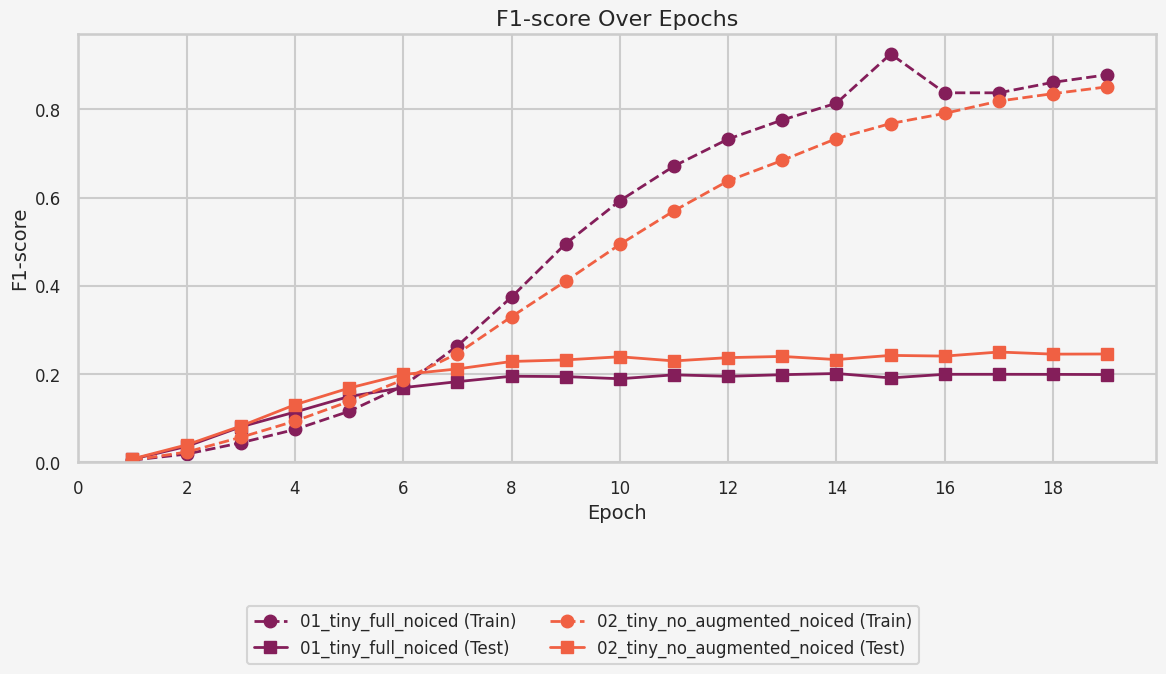

In [10]:


sns.set_theme(style="whitegrid", context="talk", palette="rocket")
plt.style.use('reports.mplstyle')

folder_path = "./bird_whisperer/experiments/results"
metrics = ["f1-score"]
results = {}

for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = json.load(f)
        
        model_name = os.path.splitext(filename)[0]
        results[model_name] = {"train": {}, "test": {}}
        
        train_data = data.get("train_metrics", [])
        test_data = data.get("test_metrics", [])
        
        for m in metrics:
            results[model_name]["train"][m] = [epoch_data[m] for epoch_data in train_data if m in epoch_data]
            results[model_name]["test"][m] = [epoch_data[m] for epoch_data in test_data if m in epoch_data]

model_names = list(results.keys())

min_train_length = min(len(results[mn]["train"][metrics[0]]) for mn in model_names)
min_test_length = min(len(results[mn]["test"][metrics[0]]) for mn in model_names)
num_epochs = min(min_train_length, min_test_length)
epochs = range(1, num_epochs + 1)

fig, ax = plt.subplots(nrows=1, ncols=len(metrics), figsize=(12, 6))
if len(metrics) == 1:
    axes = [ax]
else:
    axes = ax

color_palette = sns.color_palette(palette_name, n_colors=len(model_names))

for i, m in enumerate(metrics):
    current_ax = axes[i]

    for idx, model_name in enumerate(model_names):
        train_values = results[model_name]["train"][m][:num_epochs]
        test_values = results[model_name]["test"][m][:num_epochs]
        
        color = color_palette[idx]

        current_ax.plot(
            epochs, train_values, 
            label=f"{model_name} (Train)", 
            marker='o', 
            linestyle='--', 
            linewidth=2,
            color=color
        )
        
        current_ax.plot(
            epochs, test_values, 
            label=f"{model_name} (Test)", 
            marker='s', 
            linestyle='-', 
            linewidth=2,
            color=color
        )
    
    current_ax.set_title(f"{m.capitalize()} Over Epochs")
    current_ax.set_xlabel("Epoch")
    current_ax.set_ylabel(m.capitalize())
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    current_ax.set_ylim(bottom=0)
    current_ax.set_xlim(left=0)

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.subplots_adjust(bottom=0.2) 
plt.show()



# Data Splitting

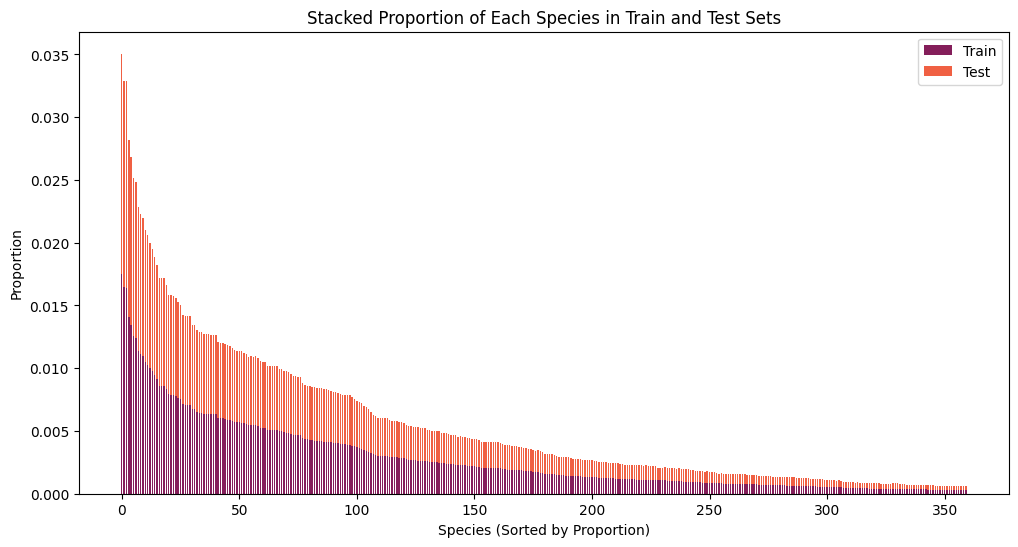

In [11]:
plt.rcdefaults()
sns.reset_orig()

file_location = "../data/cleaned/cleaned_data.parquet"
df = pd.read_parquet(file_location)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['en'], random_state=42)

train_props = train_df['en'].value_counts(normalize=True).sort_index()

test_props = test_df['en'].value_counts(normalize=True).sort_index()

distribution_df = pd.DataFrame({
    'Train': train_props,
    'Test': test_props
}).fillna(0)  

distribution_df = distribution_df.sort_values(by='Train', ascending=False)
color_palette = sns.color_palette(palette_name, 2)
species_indices = np.arange(len(distribution_df)) 
plt.figure(figsize=(12, 6))

plt.bar(species_indices, distribution_df['Train'], width=0.6, label='Train', color=color_palette[0])
plt.bar(species_indices, distribution_df['Test'], width=0.6, label='Test', bottom=distribution_df['Train'] , color=color_palette[1])

plt.xlabel('Species (Sorted by Proportion)')
plt.ylabel('Proportion')
plt.title('Stacked Proportion of Each Species in Train and Test Sets')
plt.legend()

plt.show()

# Spectrograms

/tmp/ipykernel_20586/1416445613.py:32: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y_original, sr=sr_original, x_axis='time', color=color_palette[0], alpha=0.7)


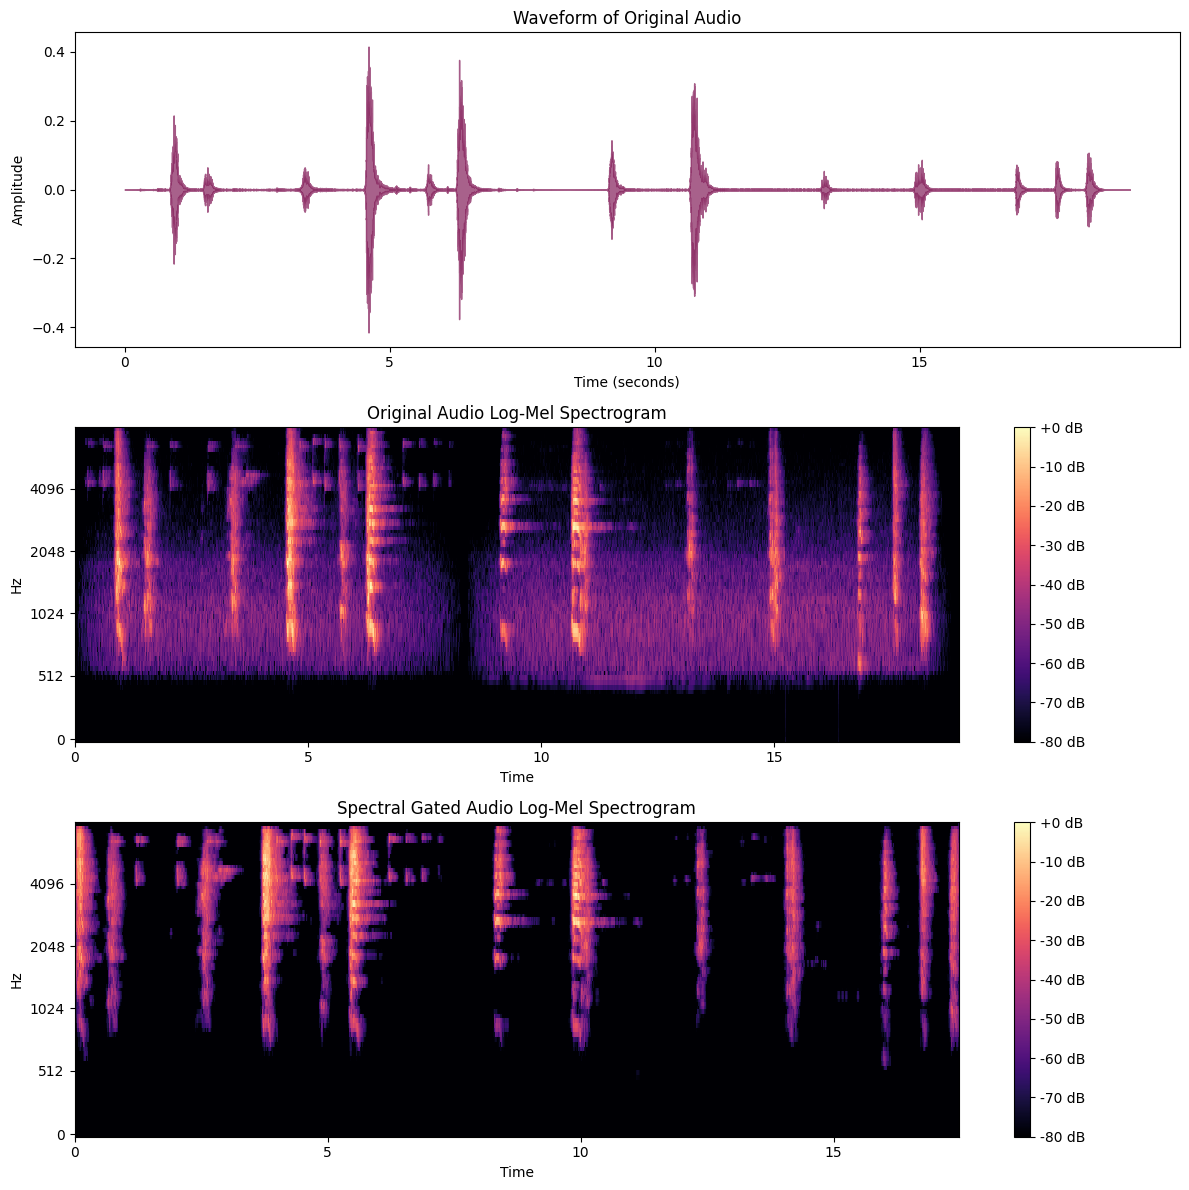

In [12]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

OUTPUT_AUDIO_DIR = '../data/TEST'
audio_id = 378737

original_audio_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_original.mp3")
spectral_gated_audio_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_spectral_gating.mp3")
normalized_audio_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_normalized.mp3")

y_original, sr_original = librosa.load(original_audio_path, sr=16000)
y_spectral_gated, sr_spectral_gated = librosa.load(spectral_gated_audio_path, sr=16000)
y_normalized, sr_normalized = librosa.load(normalized_audio_path, sr=16000)

n_mels = 80  
n_fft = 400
hop_length = 160

mel_original = librosa.feature.melspectrogram(y=y_original, sr=sr_original, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_db_original = librosa.power_to_db(mel_original, ref=np.max)

mel_spectral_gated = librosa.feature.melspectrogram(y=y_spectral_gated, sr=sr_spectral_gated, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_db_spectral_gated = librosa.power_to_db(mel_spectral_gated, ref=np.max)

plt.figure(figsize=(12, 12))


plt.subplot(3, 1, 1)
librosa.display.waveshow(y_original, sr=sr_original, x_axis='time', color=color_palette[0], alpha=0.7)
plt.title('Waveform of Original Audio')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
librosa.display.specshow(mel_db_original, sr=sr_original, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio Log-Mel Spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(mel_db_spectral_gated, sr=sr_spectral_gated, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectral Gated Audio Log-Mel Spectrogram')

plt.tight_layout()
plt.show()

# Length of all recordings

In [37]:
import os
from mutagen.mp3 import MP3
from mutagen.wave import WAVE
import matplotlib.pyplot as plt

RAW_AUDIO_DIR = "../data/raw/audio/xeno_canto"

file_lengths = {}

for filename in os.listdir(RAW_AUDIO_DIR):
    if filename.endswith(".mp3") or filename.endswith(".wav"):
        filepath = os.path.join(RAW_AUDIO_DIR, filename)
        try:
            if filename.endswith(".mp3"):
                audio = MP3(filepath)
                duration = audio.info.length
            elif filename.endswith(".wav"):
                audio = WAVE(filepath)
                duration = audio.info.length
            file_lengths[filename] = duration
        except Exception as e:
            print(f"Error processing {filename}: {e}")



Error processing 745974.wav: Invalid chunk ID 'ID3\x04'
Error processing 483205.mp3: can't sync to MPEG frame
Error processing 698419.wav: Invalid chunk ID 'ID3\x04'
Error processing 673091.wav: Invalid chunk ID 'ID3\x04'
Error processing 901402.wav: 
Error processing 673083.wav: Invalid chunk ID 'ID3\x04'
Error processing 845145.wav: 
Error processing 701858.mp3: can't sync to MPEG frame
Error processing 628436.mp3: can't sync to MPEG frame
Error processing 356231.mp3: can't sync to MPEG frame
Error processing 676173.wav: Invalid chunk ID 'ID3\x04'
Error processing 785737.wav: 
Error processing 671766.wav: Invalid chunk ID 'ID3\x04'
Error processing 761864.wav: Invalid chunk ID 'ID3\x04'
Error processing 470775.mp3: can't sync to MPEG frame
Error processing 340489.mp3: can't sync to MPEG frame
Error processing 648100.wav: Invalid chunk ID 'ID3\x04'
Error processing 804052.wav: 
Error processing 928455.wav: 
Error processing 780239.wav: Invalid chunk ID 'ID3\x04'
Error processing 71345

Number of files with durations over 30 seconds (dropped): 171


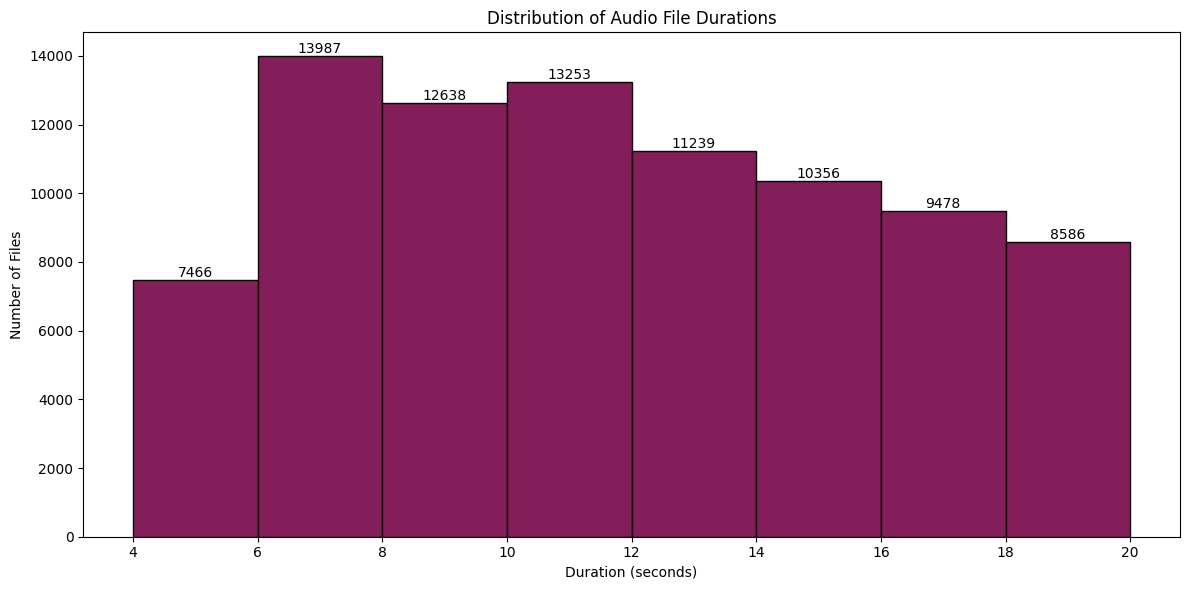

In [52]:
durations = list(file_lengths.values())

filtered_durations = [d for d in durations if d <= 20]
dropped_count = len(durations) - len(filtered_durations)

print(f"Number of files with durations over 30 seconds (dropped): {dropped_count}")

bin_size = 2
bin_edges = np.arange(4, 21, bin_size)  

hist_counts, edges = np.histogram(filtered_durations, bins=bin_edges)

bin_centers = (edges[:-1] + edges[1:]) / 2  

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, hist_counts, width=bin_size, align="center", color=color_palette[0], edgecolor="black")

# Annotate each bar with the count
def add_labels(bin_centers, hist_counts):
    for center, count in zip(bin_centers, hist_counts):
        plt.text(center, count + 0.2, str(count), ha='center', va='bottom', fontsize=10, color='black')

add_labels(bin_centers, hist_counts)

plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Files')
plt.title('Distribution of Audio File Durations')

plt.xticks(edges, labels=[str(int(x)) for x in edges])
plt.tight_layout()
plt.show()

# Baseline Results Metrics 

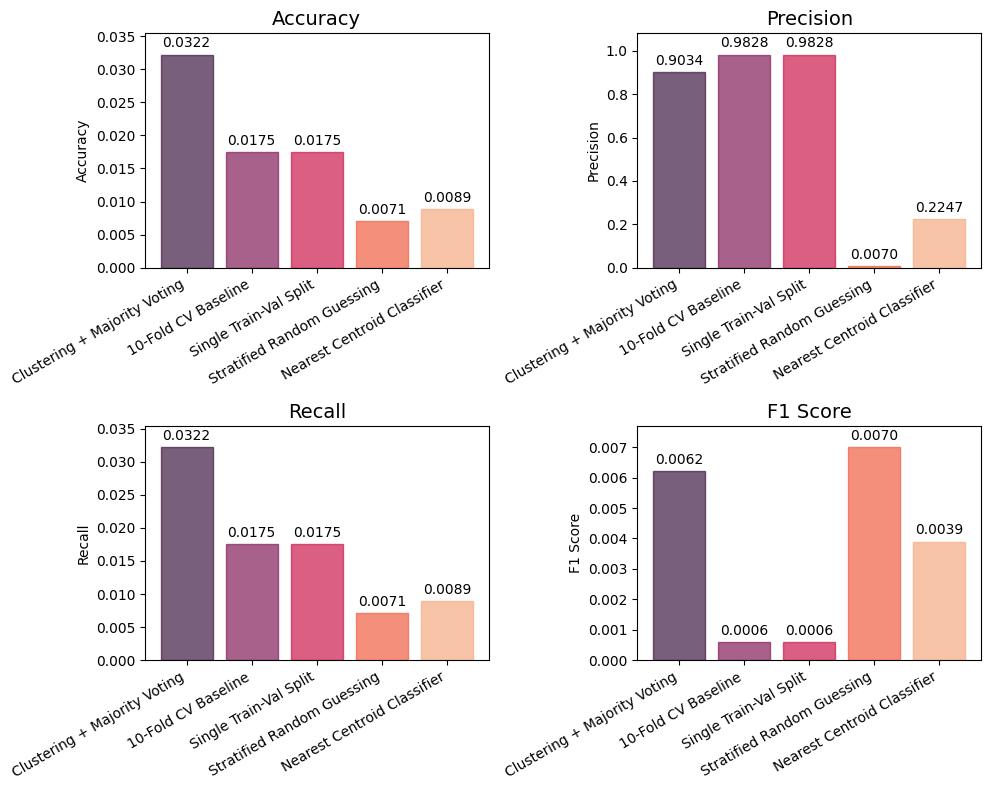

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the data
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = [
    "Clustering + Majority Voting",
    "10-Fold CV Baseline",
    "Single Train-Val Split",
    "Stratified Random Guessing",
    "Nearest Centroid Classifier"
]
data = [
    [0.0322, 0.9034, 0.0322, 0.0062],  # Clustering + Majority Voting
    [0.0175, 0.9828, 0.0175, 0.0006],  # 10-Fold CV Baseline
    [0.0175, 0.9828, 0.0175, 0.0006],  # Single Train-Val Split
    [0.0071, 0.0070, 0.0071, 0.0070],  # Stratified Random Guessing
    [0.0089, 0.2247, 0.0089, 0.0039]   # Nearest Centroid Classifier
]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

data_transposed = list(zip(*data))
x = np.arange(len(models))
max_values = [max(metric_values) for metric_values in data_transposed]

color_palette = sns.color_palette(palette_name, len(models))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    bars = axes[i].bar(x, data_transposed[i], tick_label=models, alpha=0.7)
    for j, bar in enumerate(bars):
        bar.set_color(color_palette[j])  
        height = bar.get_height()
        axes[i].annotate(f'{height:.4f}',  
                         xy=(bar.get_x() + bar.get_width() / 2, height), 
                         xytext=(0, 3), 
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=10)
    axes[i].set_title(f'{metric}', fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(models, rotation=30, ha="right")
    axes[i].set_ylim(0, max_values[i] * 1.1)

fig.tight_layout()
plt.show()
